<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  This material largely follows the text "Numerical Linear Algebra" by Trefethen and Bau (SIAM, 1997) and is meant as a guide and supplement to the material presented there.

In [2]:
%matplotlib inline
%precision 3
import numpy
import matplotlib.pyplot as plt

# Numerical Linear Algebra

Numerical methods for linear algebra problems lies at the heart of many numerical approaches and is something we will spend some time on.  Roughly we can break down problems that we would like to solve into two general problems, solving a system of equations

$$A \mathbf{x} = \mathbf{b}$$

and solving the eigenvalue problem

$$A \mathbf{v} = \lambda \mathbf{v}.$$

We examine each of these problems separately and will evaluate some of the fundamental properties and methods for solving these problems. We will be careful in deciding how to evaluate the results of our calculations and try to gain some understanding of when and how they fail.

## General Problem Specification

The number and power of the different tools made available from the study of linear algebra makes it an invaluable field of study. Before we dive in to numerical approximations we first consider some of the pivotal problems that numerical methods for linear algebra are used to address.

For this discussion we will be using the common notation $m \times n$ to denote the dimensions of a matrix $A$.  The $m$ refers to the number of rows and $n$ the number of columns.  If a matrix is square, i.e. $m = n$, then we will use the notation that $A$ is $m \times m$.

### Systems of Equations

The first type of problem is to find the solution to a linear system of equations.  If we have $m$ equations for $m$ unknowns it can be written in matrix/vector form,

$$A \mathbf{x} = \mathbf{b}.$$

For this example $A$ is an $m \times m$ matrix, denoted as being in $\mathbb{R}^{m\times m}$, and $\mathbf{x}$ and $\mathbf{b}$ are column vectors with $m$ entries, denoted as $\mathbb{R}^m$.

#### Example: Vandermonde Matrix

We have data $(x_i, y_i), ~~ i = 1, 2, \ldots, m$ that we want to fit a polynomial of order $m-1$.  Solving the linear system $A \mathbf{p} = \mathbf{y}$ does this for us where

$$A = \begin{bmatrix}
    1 & x_1 & x_1^2 & \cdots & x_1^{m-1} \\
    1 & x_2 & x_2^2 & \cdots & x_2^{m-1} \\
    \vdots & \vdots & \vdots & & \vdots \\
    1 & x_m & x_m^2 & \cdots & x_m^{m-1}
\end{bmatrix} \quad \quad \mathbf{y} = \begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_m
\end{bmatrix}$$

and $\mathbf{p}$ are the coefficients of the interpolating polynomial $\mathcal{P}_N(x) = p_0 + p_1 x + p_2 x^2 + \cdots + p_m x^{m-1}$. The solution to this system satisfies $\mathcal{P}_N(x_i)=y_i$ for $i=1, 2, \ldots, m$.

#### Example: Linear least squares 1

In a similar case as above, say we want to fit a particular function (could be a polynomial) to a given number of data points except in this case we have more data points than free parameters.  In the case of polynomials this could be the same as saying we have $m$ data points but only want to fit a $n - 1$ order polynomial through the data where $n - 1 \leq m$.  One of the common approaches to this problem is to minimize the "least-squares" error between the data and the resulting function:
$$
    E = \left( \sum^m_{i=1} |y_i - f(x_i)|^2 \right )^{1/2}.
$$

But how do we do this if our matrix $A$ is now $m \times n$ and looks like
$$
    A = \begin{bmatrix}
        1 & x_1 & x_1^2 & \cdots & x_1^{n-1} \\
        1 & x_2 & x_2^2 & \cdots & x_2^{n-1} \\
        \vdots & \vdots & \vdots & & \vdots \\
        1 & x_m & x_m^2 & \cdots & x_m^{n-1}
    \end{bmatrix}?
$$

Turns out if we solve the system

$$A^T A \mathbf{x} = A^T \mathbf{b}$$

we can guarantee that the error is minimized in the least-squares sense[<sup>1</sup>](#footnoteRegression). (Although we will also show that this is not the most numerically stable way to solve this problem)



#### Example:  Linear least squares 2

Fitting a line through data that has random noise added to it.

In [29]:
# Linear Least Squares Problem

# First define the independent and dependent variables.
N = 20
x = numpy.linspace(-1.0, 1.0, N)
y = x + numpy.random.random((N)) 

# Define the Vandermonde matrix based on our x-values
A = numpy.array([ numpy.ones(x.shape), x]).T
#A = numpy.array([ numpy.ones(x.shape), x, x**2]).T

In [30]:
# Determine the coefficients of the polynomial that will
# result in the smallest sum of the squares of the residual.
p = numpy.linalg.solve(numpy.dot(A.transpose(), A), numpy.dot(A.transpose(), y))
print("Error in slope = %s, y-intercept = %s" % (numpy.abs(p[1] - 1.0), numpy.abs(p[0] - 0.5)))
print(p)

Error in slope = 0.05746843928566736, y-intercept = 0.008366326633092502
[0.492 0.943]


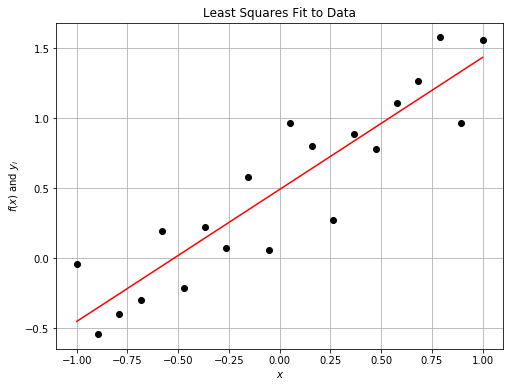

In [32]:
# Plot it out, cuz pictures are fun!
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

f = numpy.zeros(x.shape)
for i in range(len(p)):
    f += p[i] * x**i
axes.plot(x, y, 'ko')
axes.plot(x, f, 'r')
axes.set_title("Least Squares Fit to Data")
axes.set_xlabel("$x$")
axes.set_ylabel("$f(x)$ and $y_i$")
axes.grid()

plt.show()

### Eigenproblems

Eigenproblems come up in a variety of contexts and often are integral to many problem of scientific and engineering interest. It is such a powerful idea that it is not uncommon for us to take a problem and convert it into an eigenproblem. Here we introduce the idea and give some examples.

As a review, if $A \in \mathbb{C}^{m\times m}$ (a square matrix with complex values), a non-zero vector $\mathbf{v}\in\mathbb{C}^m$ is an **eigenvector** of $A$ with a corresponding **eigenvalue** $\lambda \in \mathbb{C}$ if 

$$A \mathbf{v} = \lambda \mathbf{v}.$$

One way to interpret the eigenproblem is that we are attempting to ascertain the "action" of the matrix $A$ on some subspace of $\mathbb{C}^m$ where this action acts like scalar multiplication.  This subspace is called an **eigenspace**.

### General idea of EigenProblems

Rewriting the standard Eigen problem $A\mathbf{v}=\lambda\mathbf{v}$ for $A \in \mathbb{C}^{m\times m}$, $\mathbf{v}\in\mathbb{C}^m$ as

$$
    (A - \lambda I)\mathbf{v} = 0
$$ 

it becomes clear that for $\mathbf{v}$ to be non-trivial (i.e. $\neq \mathbf{0}$), requires that the matrix $(A-\lambda I)$ be singular,  

This is equivalent to finding all values of $\lambda$ such that $|A-\lambda I| = 0$ (the determinant of singular matrices is always zero).  However, it can also be shown that 

$$
   | A-\lambda I| = P_m(\lambda)
$$

which is a $m$th order polynomial in $\lambda$.  Thus $P_m(\lambda)=0$ implies the eigenvalues are the $m$ roots of $P$, and the **eigenspace** corresponding to $\lambda_i$ is just $N(A-\lambda_i I)$


### Solving EigenProblems

The temptation (and what) we usually teach in introductory linear algebra is to simply find the roots of $P_m(\lambda)$.  However that would be **wrong**.  The best algorithms for finding Eigenvalues are completely unrelated to rootfinding as we shall see.

#### Example

Compute the eigenspace of the matrix
$$
    A = \begin{bmatrix}
        1 & 2 \\
        2 & 1
    \end{bmatrix}
$$

Recall that we can find the eigenvalues of a matrix by computing $\det(A - \lambda I) = 0$.  

In this case we have
$$\begin{aligned}
    A - \lambda I &= \begin{bmatrix}
        1 & 2 \\
        2 & 1
    \end{bmatrix} - \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \lambda\\
    &= \begin{bmatrix}
        1 - \lambda & 2 \\
        2 & 1 - \lambda
    \end{bmatrix}.
\end{aligned}$$
The determinant of the matrix is
$$\begin{aligned}
\begin{vmatrix}
    1 - \lambda & 2 \\
    2 & 1 - \lambda
\end{vmatrix} &= (1 - \lambda) (1 - \lambda) - 2 \cdot 2 \\
&= 1 - 2 \lambda + \lambda^2 - 4 \\
&= \lambda^2 - 2 \lambda - 3.
\end{aligned}$$
This result is sometimes referred to as the characteristic equation of the matrix, $A$.

Setting the determinant equal to zero we can find the eigenvalues as
$$\begin{aligned}
    & \\
    \lambda &= \frac{2 \pm \sqrt{4 - 4 \cdot 1 \cdot (-3)}}{2} \\
    &= 1 \pm 2 \\
    &= -1 \mathrm{~and~} 3
\end{aligned}$$

The eigenvalues are used to determine the eigenvectors. The eigenvectors are found by going back to the equation $(A - \lambda I) \mathbf{v}_i = 0$ and solving for each vector.  A trick that works some of the time is to normalize each vector such that the first entry is 1 ($\mathbf{v}_1 = 1$):

$$
    \begin{bmatrix}
        1 - \lambda & 2 \\
        2 & 1 - \lambda
    \end{bmatrix} \begin{bmatrix} 1 \\ v_2 \end{bmatrix} = 0
$$

$$\begin{aligned}
    1 - \lambda + 2 v_2 &= 0 \\
    v_2 &= \frac{\lambda - 1}{2}
\end{aligned}$$

We can check this by
$$\begin{aligned}
    2 + \left(1- \lambda \frac{\lambda - 1}{2}\right) & = 0\\
    (\lambda - 1)^2 - 4 &=0
\end{aligned}$$

which by design is satisfied by our eigenvalues.  Another sometimes easier approach is to plug-in the eigenvalues to   find the Null space of $A-\lambda I$ where the eigenvectors will be a basis for $N(A-\lambda I)$.  The eigenvectors are therefore

$$\mathbf{v} = \begin{bmatrix}1 \\ -1 \end{bmatrix}, \begin{bmatrix}1 \\ 1 \end{bmatrix}.$$

Note that these are linearly independent (and because $A^T = A$, also orthogonal)

## Fundamentals

### Matrix-Vector Multiplication

One of the most basic operations we can perform with matrices is to multiply them be a vector.  This matrix-vector product $A \mathbf{x} = \mathbf{b}$ is defined as
$$
    b_i = \sum^n_{j=1} a_{ij} x_j \quad \text{where}\quad i = 1, \ldots, m
$$

### row picture
In addition to index form, we can consider matrix-vector as a sequence of inner products (dot-products between the rows of $A$ and the vector $\mathbf{x}$.  
\begin{align}
    \mathbf{b} &= A \mathbf{x}, \\
     &= 
    \begin{bmatrix}  \mathbf{a}_1^T \mathbf{x} \\ \mathbf{a}_2^T \mathbf{x} \\ \vdots \\ \mathbf{a}_m^T \mathbf{x}\end{bmatrix}
\end{align}
where $\mathbf{a}_i^T$ is the $i$th **row** of $A$

#### Operation Counts
This view is convenient for calculating the **Operation counts** required for to compute $A\mathbf{x}$.  If $A\in\mathbb{C}^{m\times n}$ and $\mathbf{x}\in\mathbb{C}^n$.  Then just counting the number of multiplications involved to compute $A\mathbf{x}$ is $O(??)$


### Column picture

An alternative (and entirely equivalent way) to write the matrix-vector product is as a linear combination of the columns of $A$ where each column's weighting is $x_j$.

$$
\begin{align}
    \mathbf{b} &= A \mathbf{x}, \\
    &= 
    \begin{bmatrix}  &  &  &  \\  &  &  &  \\ \mathbf{a}_1 & \mathbf{a}_2 & \cdots & \mathbf{a}_n \\  &  &  &   \\  &  &  &  \end{bmatrix}
    \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}, \\
  &= x_1 \mathbf{a}_1 + x_2 \mathbf{a}_2 + \cdots + x_n \mathbf{a}_n.
\end{align}
$$

This view will be useful later when we are trying to interpret various types of matrices.

One important property of the matrix-vector product is that is a **linear** operation, also known as a **linear operator**.  This means that the for any $\mathbf{x}, \mathbf{y} \in \mathbb{C}^n$ and any $c \in \mathbb{C}$ we know that

1. $A (\mathbf{x} + \mathbf{y}) = A\mathbf{x} + A\mathbf{y}$
1. $A\cdot (c\mathbf{x}) = c A \mathbf{x}$

#### Example:  Vandermonde Matrix

In the case where we have $m$ data points and want $m - 1$ order polynomial interpolant the matrix $A$ is a square, $m \times m$, matrix as before.  Using the above interpretation the polynomial coefficients $p$ are the weights for each of the monomials that give exactly the $y$ values of the data.

#### Example:  Numerical matrix-vector multiply

Write a matrix-vector multiply function and check it with the appropriate `numpy` routine.  Also verify the linearity of the matrix-vector multiply.

In [4]:
#A x = b
#(m x n) (n x 1) = (m x 1)
def matrix_vector_product(A, x):
    m, n = A.shape
    b = numpy.zeros(m)
    for i in range(m):
        for j in range(n):
            b[i] += A[i, j] * x[j]
    return b

m = 4
n = 3
A = numpy.random.uniform(size=(m,n))
x = numpy.random.uniform(size=(n))
y = numpy.random.uniform(size=(n))
c = numpy.random.uniform()
b = matrix_vector_product(A, x)
print(numpy.allclose(b, numpy.dot(A, x)))
print(numpy.allclose(matrix_vector_product(A, (x + y)), matrix_vector_product(A, x) + matrix_vector_product(A, y)))
print(numpy.allclose(matrix_vector_product(A, c * x), c*matrix_vector_product(A, x)))

True
True
True


### Matrix-Matrix Multiplication

The matrix product with another matrix $A B = C$ is defined as
$$
    c_{ij} = \sum^m_{k=1} a_{ik} b_{kj} = \mathbf{a}_i^T\mathbf{b}_j
$$

i.e. each component of $C$ is a dot-product between the $i$th row of $A$ and the $j$th column of $B$

As with matrix-vector multiplication, Matrix-matrix multiplication can be thought of multiple ways

* $m\times p$ dot products
* $A$ multiplying the columns of $B$
$$
    C = AB = \begin{bmatrix} 
                A\mathbf{b}_1 & A\mathbf{b}_2 & \ldots & A\mathbf{b}_p\\ 
             \end{bmatrix}
$$
* Linear combinations of the rows of $B$
$$
C = AB = \begin{bmatrix} 
                \mathbf{a}_1^T B \\ \mathbf{a}_2^T B \\ \vdots \\ \mathbf{a}_m^T B\\ 
             \end{bmatrix}
$$

### Questions
* What are the dimensions of $A$ and $B$ so that the multiplication works?
* What are the Operations Counts for Matrix-Matrix Multiplication?
* Comment on the product $\mathbf{c}=(AB)\mathbf{x}$ vs. $\mathbf{d} = A(B\mathbf{x})$

#### Example:  Outer Product

The product of two vectors $\mathbf{u} \in \mathbb{C}^m$ and $\mathbf{v} \in \mathbb{C}^n$ is a $m \times n$ matrix where the columns are the vector $u$ multiplied by the corresponding value of $v$:
$$
\begin{align}
    \mathbf{u} \mathbf{v}^T &= 
    \begin{bmatrix}  u_1 \\ u_2 \\ \vdots \\ u_n  \end{bmatrix}
    \begin{bmatrix} v_1 & v_2 & \cdots & v_n \end{bmatrix}, \\
    & = \begin{bmatrix} v_1u_1 & \cdots & v_n u_1 \\ \vdots &  & \vdots \\ v_1 u_m & \cdots & v_n u_m \end{bmatrix}.
\end{align}
$$

It is useful to think of these as operations on the column vectors, and an equivalent way to express this relationship is 
$$
\begin{align}
    \mathbf{u} \mathbf{v}^T &=
    \begin{bmatrix}  \\ \mathbf{u} \\ \\  \end{bmatrix}
    \begin{bmatrix} v_1 & v_2 & \cdots & v_n \end{bmatrix}, \\
    &=
    \begin{bmatrix}  &  &  &  \\  &  &  &  \\ \mathbf{u}v_1  & \mathbf{u} v_2  & \cdots & \mathbf{u} v_n  \\  &  &  & \\  &  &  &  \end{bmatrix}, \\
    & = \begin{bmatrix} v_1u_1 & \cdots & v_n u_1 \\ \vdots &  & \vdots \\ v_1 u_m & \cdots & v_n u_m \end{bmatrix}.
\end{align}
$$

### rank 1 updates

We call any matrix of the form $\mathbf{u}\mathbf{v}^T$ a "rank one matrix"  ( because its rank r=?).  These sort of matrix operations are very common in numerical algorithms for orthogonalization, eigenvalues and the original page-rank algorithm for google.  Again, the order of operations is critical.

Comment on the difference in values and operation counts between

$$
    \mathbf{y} = (\mathbf{u}\mathbf{v}^T)\mathbf{x}
$$

and 
$$
    \mathbf{y}' = \mathbf{u}(\mathbf{v}^T\mathbf{x})
$$
for $\mathbf{u}$, $\mathbf{v}$, $\mathbf{x}$, $\mathbf{y}$, $\mathbf{y}'\in\mathbb{R}^n$, 

#### Example:  Upper Triangular Multiplication

Consider the multiplication of a matrix $A \in \mathbb{C}^{m\times n}$ and the **upper-triangular** matrix $R$ defined as the $n \times n$ matrix with entries $r_{ij} = 1$ for $i \leq j$ and $r_{ij} = 0$ for $i > j$.  The product can be written as
$$
    \begin{bmatrix}  \\  \\ \mathbf{b}_1 & \cdots & \mathbf{b}_n \\ \\ \\ \end{bmatrix} = \begin{bmatrix} \\ \\  \mathbf{a}_1 & \cdots & \mathbf{a}_n \\ \\ \\ \end{bmatrix} \begin{bmatrix} 1 & \cdots & 1 \\  & \ddots & \vdots \\  &  & 1 \end{bmatrix}.
$$

The columns of $B$ are then
$$
    \mathbf{b}_j = A \mathbf{r}_j = \sum^j_{k=1} \mathbf{a}_k
$$
so that $\mathbf{b}_j$ is the sum of the first $j$ columns of $A$.

#### Example: Write Matrix-Matrix Multiplication

Write a function that computes matrix-matrix multiplication and demonstrate the following properties:
1. $A (B + C) = AB + AC$ (for square matrices))
1. $A (cB) = c AB$ where $c \in \mathbb{C}$
1. $AB \neq BA$ in general

In [5]:
def matrix_matrix_product(A, B):
    C = numpy.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i, j] += A[i, k] * B[k, j]
    return C


m = 4
n = 4
p = 4
A = numpy.random.uniform(size=(m, n))
B = numpy.random.uniform(size=(n, p))
C = numpy.random.uniform(size=(m, p))
c = numpy.random.uniform()
print(numpy.allclose(matrix_matrix_product(A, B), numpy.dot(A, B)))
print(numpy.allclose(matrix_matrix_product(A, (B + C)), matrix_matrix_product(A, B) + matrix_matrix_product(A, C)))
print(numpy.allclose(matrix_matrix_product(A, c * B), c*matrix_matrix_product(A, B)))
print(numpy.allclose(matrix_matrix_product(A, B), matrix_matrix_product(B, A)))

True
True
True
False


#### NumPy Products

NumPy and SciPy contain routines that are optimized to perform matrix-vector and matrix-matrix multiplication.  Given two `ndarray`s you can take their product by using the `dot` function.

In [6]:
n = 10
m = 5
# Matrix vector with identity
A = numpy.identity(n)
x = numpy.random.random(n)
print(numpy.allclose(x, numpy.dot(A, x)))

# Matrix vector product
A = numpy.random.random((m, n))
print(numpy.dot(A, x))

# Matrix matrix product
B = numpy.random.random((n, m))
print(numpy.dot(A, B))

True
[3.971 3.373 2.333 3.141 3.895]
[[3.699 2.14  3.33  2.959 3.747]
 [2.682 2.123 2.93  2.808 2.38 ]
 [2.212 1.182 1.971 1.727 2.129]
 [2.7   1.727 2.003 2.334 1.777]
 [2.513 2.206 2.94  3.025 2.619]]


### Range and Null-Space

#### Range
- The **range** of a matrix $A \in \mathbb R^{m \times n}$ (similar to any function), denoted as $\text{range}(A)$, is the set of vectors that can be expressed as $A x$ for $x \in \mathbb R^n$.  
- We can also then say that that $\text{range}(A)$ is the space **spanned** by the columns of $A$.  In other words the columns of $A$ provide a basis for $\text{range}(A)$, also called the **column space** of the matrix $A$.  

#### Null-Space
- Similarly the **null-space** of a matrix $A$, denoted $\text{null}(A)$ is the set of vectors $x$ that satisfy $A x = 0$.
- A similar concept is the **rank** of the matrix $A$, denoted as $\text{rank}(A)$, is the dimension of the column space.  A matrix $A$ is said to have **full-rank** if $\text{rank}(A) = \min(m, n)$.  This property also implies that the matrix mapping is **one-to-one**.

### Inverse

A **non-singular** or **invertible** matrix is characterized as a matrix with full-rank.  This is related to why we know that the matrix is one-to-one, we can use it to transform a vector $x$ and using the inverse, denoted $A^{-1}$, we can map it back to the original matrix.  The familiar definition of this is
\begin{align*}
    A \mathbf{x} &= \mathbf{b}, \\
    A^{-1} A \mathbf{x} & = A^{-1} \mathbf{b}, \\
    x &=A^{-1} \mathbf{b}.
\end{align*}
Since $A$ has full rank, its columns form a basis for $\mathbb{R}^m$ and the vector $\mathbf{b}$ must be in the column space of $A$.

There are a number of important properties of a non-singular matrix A.  Here we list them as the following equivalent statements
1. $A$ has an inverse $A^{-1}$
1. $\text{rank}(A) = m$
1. $\text{range}(A) = \mathbb{C}^m$
1. $\text{null}(A) = {0}$
1. 0 is not an eigenvalue of $A$
1. $\text{det}(A) \neq 0$

#### Example:  Properties of invertible matrices

Show that given an invertible matrix that the rest of the properties hold.  Make sure to search the `numpy` packages for relevant functions.

In [12]:
m = 3
for n in range(100):
    A = numpy.random.uniform(size=(m, m))
    if numpy.linalg.det(A) != 0:
        break
        
print(numpy.dot(numpy.linalg.inv(A), A))
print(numpy.linalg.matrix_rank(A))
print("N(A)= {}".format(numpy.linalg.solve(A, numpy.zeros(m))))
print("Eigenvalues = {}".format(numpy.linalg.eigvals(A)))

[[ 1.000e+00  4.638e-16 -3.615e-16]
 [ 3.611e-17  1.000e+00 -1.384e-17]
 [ 7.788e-17  9.358e-16  1.000e+00]]
3
N(A)= [0. 0. 0.]
Eigenvalues = [ 1.454  0.585 -0.064]


### Orthogonal Vectors and Matrices

Orthogonality is a very important concept in linear algebra that forms the basis of many of the modern methods used in numerical computations.  

Two vectors are said to be *orthogonal* if their **inner-product** or **dot-product** defined as
$$
    < \mathbf{x}, \mathbf{y} > \equiv (\mathbf{x}, \mathbf{y}) \equiv \mathbf{x}^T\mathbf{y} \equiv \mathbf{x} \cdot \mathbf{y} = \sum^m_{i=1} x_i y_i = 0
$$
Here we have shown the various notations you may run into (the inner-product is in-fact a general term for a similar operation for mathematical objects such as functions).  

If $\langle \mathbf{x},\mathbf{y} \rangle = 0$ then we say $\mathbf{x}$ and $\mathbf{y}$ are orthogonal.  The reason we use this terminology is that the inner-product of two vectors can also be written in terms of the angle between them where
$$
    \cos \theta = \frac{\langle \mathbf{x}, \mathbf{y} \rangle}{||\mathbf{x}||_2~||\mathbf{y}||_2}
$$
and $||\mathbf{x}||_2$ is the Euclidean ($\ell^2$) norm of the vector $\mathbf{x}$.  

We can write this in terms of the inner-product as well as
$$
    ||\mathbf{x}||_2^2 = \langle \mathbf{x}, \mathbf{x} \rangle = \mathbf{x}^T\mathbf{x} = \sum^m_{i=1} |x_i|^2.
$$

The generalization of the inner-product to complex spaces is defined as
$$
    \langle x, y \rangle = \sum^m_{i=1} x_i^* y_i
$$
where $x_i^*$ is the complex-conjugate of the value $x_i$.

#### Orthonormality

Taking this idea one step further we can say a set of vectors $\mathbf{x} \in X$ are orthogonal to $\mathbf{y} \in Y$ if $\forall \mathbf{x},\mathbf{y}$ $< \mathbf{x}, \mathbf{y} > = 0$.  If $\forall \mathbf{x},\mathbf{y}$ $||\mathbf{x}|| = 1$ and $||\mathbf{y}|| = 1$ then they are also called orthonormal. Note that we dropped the 2 as a subscript to the notation for the norm of a vector. Later we will explore other ways to define a norm of a vector other than the Euclidean norm defined above.

Another concept that is related to orthogonality is linear-independence.  A set of vectors $\mathbf{x} \in X$ are **linearly independent** if $\forall \mathbf{x} \in X$ that each $\mathbf{x}$ cannot be written as a linear combination of the other vectors in the set $X$. 



An equivalent statement is that given a set of $n$ vectors $\mathbf{x}_i$,  the only  set of scalars $c_i$ that satisfies
$$
    \sum_{i=1}^n c_i\mathbf{x}_i = \mathbf{0}
$$
is if $c_i=0$ for all $i\in[1,n]$


This can be related directly through the idea of projection.  If we have a set of vectors $\mathbf{x} \in X$ we can project another vector $\mathbf{v}$ onto the vectors in $X$ by using the inner-product.  This is especially powerful if we have a set of **orthogonal** vectors $X$, which are said to **span** a space (or provide a **basis** for a space), s.t. any vector in the space spanned by $X$ can be expressed as a linear combination of the basis vectors $X$
$$
    \mathbf{v} = \sum^n_{i=1} \, \langle \mathbf{v}, \mathbf{x}_i \rangle \, \mathbf{x}_i.
$$
Note if $\mathbf{v} \in X$ that 
$$
    \langle \mathbf{v}, \mathbf{x}_i \rangle = 0 \quad \forall \mathbf{x}_i \in X \setminus \mathbf{v}.
$$

Looping back to matrices, the column space of a matrix is spanned by its linearly independent columns.  Any vector $v$ in the column space can therefore be expressed via the equation above.  A special class of matrices are called **unitary** matrices when complex-valued and **orthogonal** when purely real-valued if the columns of the matrix are orthonormal to each other.  Importantly this implies that for a unitary matrix $Q$ we know the following

1. $Q^* = Q^{-1}$
1. $Q^*Q = I$

where $Q^*$ is called the **adjoint** of $Q$.  The adjoint is defined as the transpose of the original matrix with the entries being the complex conjugate of each entry as the notation implies.  

As an example if we have the matrix
$$
\begin{aligned}
    Q &= \begin{bmatrix} q_{11} & q_{12} \\ q_{21} & q_{22} \\ q_{31} & q_{32} \end{bmatrix} \quad \text{then} \\
    Q^* &= \begin{bmatrix} q^*_{11} & q^*_{21} & q^*_{31} \\ q^*_{12} & q^*_{22} & q^*_{32} \end{bmatrix}
\end{aligned}
$$
The important part of being an unitary matrix is that the projection onto the column space of the matrix $Q$ preserves geometry in an Euclidean sense, i.e. preserves the Cartesian distance.

### Vector Norms

Norms (and also measures) provide a means for measure the "size" or distance in a space.  In general a norm is a function, denoted by $||\cdot||$, that maps $\mathbb{C}^m \rightarrow \mathbb{R}$.  In other words we stick in a multi-valued object and get a single, real-valued number out the other end.  All norms satisfy the properties:

1. $~~~~||\mathbf{x}|| \geq 0$
1. $~~~~||\mathbf{x}|| = 0$ only if $\mathbf{x} = \mathbf{0}$
1. $$||\mathbf{x} + \mathbf{y}||\leq ||\mathbf{x}|| + ||\mathbf{y}||$$ (triangle inequality)
1. $~~~||c \mathbf{x}|| = |c| ~ ||\mathbf{x}||$ where $c \in \mathbb{C}$

There are a number of relevant norms that we can define beyond the Euclidean norm, also know as the 2-norm or $\ell_2$ norm:

1. $\ell_1$ norm:
$$
    ||\mathbf{x}||_1 = \sum^m_{i=1} |x_i|,
$$
1. $\ell_2$ norm:
$$
    ||\mathbf{x}||_2 = \left( \sum^m_{i=1} |x_i|^2 \right)^{1/2},
$$

3. $\ell_p$ norm:
$$
    ||\mathbf{x}||_p = \left( \sum^m_{i=1} |x_i|^p \right)^{1/p}, \quad \quad 1 \leq p < \infty,
$$
1. $\ell_\infty$ norm:
$$
    ||\mathbf{x}||_\infty = \max_{1\leq i \leq m} |x_i|,
$$
1. weighted $\ell_p$ norm:
$$
    ||\mathbf{x}||_{W_p} = \left( \sum^m_{i=1} |w_i x_i|^p \right)^{1/p}, \quad \quad 1 \leq p < \infty,
$$

These are also related to other norms denoted by capital letters ($L_2$ for instance).  In this case we use the lower-case notation to denote finite or discrete versions of the infinite dimensional counterparts.

#### Example:  Comparisons Between Norms

Compute the norms given some vector $\mathbf{x}$ and compare their values.  Verify the properties of the norm for one of the norms.

In [16]:
def pnorm(x, p):
    """ return the vector p norm of a vector
    parameters:
    -----------
    x: numpy array
        vector
    p: float or numpy.inf
        value of p norm such that ||x||_p = (sum(|x_i|^p))^{1/p} for p< inf
        for infinity norm return max(abs(x))
    returns:
    --------
    pnorm: float
        pnorm of x
    """
    if p == numpy.inf:
        norm = numpy.max(numpy.abs(x))
    else:
        norm = numpy.sum(x**p)**(1./p)
    return norm

In [36]:
m = 10
p = 4
x = numpy.random.uniform(size=m)        
ell_1 = pnorm(x, 1)
ell_2 = pnorm(x, 2)
ell_p = pnorm(x, p)
ell_infty = pnorm(x, numpy.inf)

print('x = {}'.format(x))
print()
print("L_1   = {}\nL_2   = {}\nL_{}   = {}\nL_inf = {}".format(ell_1, ell_2, p, ell_p, ell_infty))

y = numpy.random.uniform(size=m)
print()
print("Properties of norms:")

print('y = {}\n'.format(y))
p = 2
print('||x+y||_{p}         = {nxy}\n||x||_{p} + ||y||_{p} = {nxny}'.format(
    p=p,nxy=pnorm(x+y, p), nxny=pnorm(x, p) + pnorm(y, p)))
c = 0.1
print('||c x||_{} = {}'.format(p,pnorm(c * x, p)))
print(' c||x||_{} = {}'.format(p,c * pnorm(x, p)))


x = [0.13  0.873 0.687 0.651 0.432 0.269 0.141 0.755 0.046 0.657]

L_1   = 4.640729989630928
L_2   = 1.719869368053674
L_4   = 1.1132227046142777
L_inf = 0.873190316333131

Properties of norms:
y = [0.906 0.667 0.01  0.979 0.084 0.701 0.697 0.245 0.576 0.411]

||x+y||_2         = 3.3204920481662685
||x||_2 + ||y||_2 = 3.6615160125333635
||c x||_2 = 0.1719869368053674
 c||x||_2 = 0.17198693680536742


### Matrix Norms

The most direct way to consider a matrix norm is those induced by a vector-norm.  Given a vector norm, we can define a matrix norm as the smallest number $C$ that satisfies the inequality
$$
    ||A \mathbf{x}||_{m} \leq C ||\mathbf{x}||_{n}.
$$
or as the supremum of the ratios so that
$$
    C = \sup_{\mathbf{x}\in\mathbb{C}^n ~ \mathbf{x}\neq\mathbf{0}} \frac{||A \mathbf{x}||_{m}}{||\mathbf{x}||_n}.
$$

Noting that $||A \mathbf{x}||$ lives in the column space and $||\mathbf{x}||$ on the domain we can think of the matrix norm as the "size" of the matrix that maps the domain to the range.  Also noting that if $||\mathbf{x}||_n = 1$ we also satisfy the condition we can write the induced matrix norm as
$$
    ||A||_{(m,n)} = \sup_{\mathbf{x} \in \mathbb{C}^n ~ ||\mathbf{x}||_{n} = 1} ||A \mathbf{x}||_{m}.
$$

#### Example: Induced Matrix Norms

Consider the matrix
$$
    A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix}.
$$
Compute the induced-matrix norm of $A$ for the vector norms $\ell_2$ and $\ell_\infty$.

$\ell^2$: For both of the requested norms the unit-length vectors $[1, 0]$ and $[0, 1]$ can be used to give an idea of what the norm might be and provide a lower bound.  

$$
    ||A||_2 = \sup_{x \in \mathbb{R}^n} \left( ||A \cdot [1, 0]^T||_2, ||A \cdot [0, 1]^T||_2 \right )
$$

computing each of the norms we have

$$\begin{aligned}
    \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 0 \end{bmatrix} &= \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
    \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 1 \end{bmatrix} &= \begin{bmatrix} 2 \\ 2 \end{bmatrix}
\end{aligned}$$

which translates into the norms $||A \cdot [1, 0]^T||_2 = 1$ and $||A \cdot [0, 1]^T||_2 = 2 \sqrt{2}$.  This implies that the $\ell_2$ induced matrix norm of $A$ is at least $||A||_{2} = 2 \sqrt{2} \approx 2.828427125$.

The exact value of $||A||_2$ can be computed using the spectral radius defined as
$$
    \rho(A) = \max_{i} |\lambda_i|,
$$
where $\lambda_i$ are the eigenvalues of $A$.  With this we can compute the $\ell_2$ norm of $A$ as
$$
    ||A||_2 = \sqrt{\rho(A^\ast A)}
$$

Computing the norm again here we find
$$
    A^\ast A = \begin{bmatrix} 1 & 0 \\ 2 & 2 \end{bmatrix} \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 2 & 8 \end{bmatrix}
$$
which has eigenvalues 
$$
    \lambda = \frac{1}{2}\left(9 \pm \sqrt{65}\right )
$$
so $||A||_2 \approx 2.9208096$.

$\ell^\infty$: We can again bound $||A||_\infty$ by looking at the unit vectors which give us the matrix lower bound of 2.  To compute it turns out $||A||_{\infty} = \max_{1 \leq i \leq m} ||a^\ast_i||_1$ where $a^\ast_i$ is the $i$th row of $A$.  This represents then the maximum of the row sums of $A$.  Therefore $||A||_\infty = 3$.

In [37]:
A = numpy.array([[1, 2], [0, 2]])
print(numpy.linalg.norm(A, ord=2))
print(numpy.linalg.norm(A, ord=numpy.infty))

2.9208096264818897
3.0


#### Example: General  Norms of a Matrix

Compute a bound on the induced norm of the $m \times n$ dimensional matrix $A$ using $\ell_1$ and $\ell_2$

One of the most useful ways to think about matrix norms is as a transformation of a unit-ball to an ellipse.  Depending on the norm in question, the norm will be some combination of the resulting ellipse.  For the above cases we have some nice relations based on these ideas.

1. $||A \mathbf{x}||_1 = || \sum^n_{j=1} x_j \mathbf{a}_j ||_1 \leq \sum^n_{j=1} |x_j| ||\mathbf{a}_j||_1 \leq \max_{1\leq j\leq n} ||\mathbf{a}_j||_1$
1. $||A \mathbf{x}||_\infty = || \sum^n_{j=1} x_j \mathbf{a_j} ||_\infty \leq \sum^n_{j=1} |x_j| ||\mathbf{a}_j||_\infty \leq \max_{1 \leq i \leq m} ||a^*_i||_1$

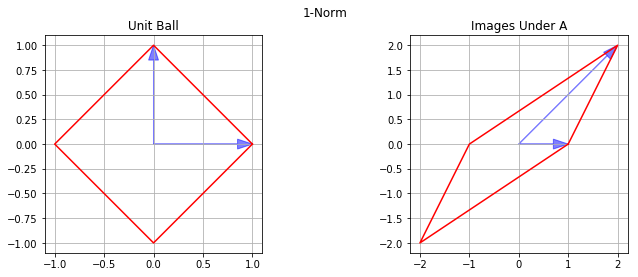

In [41]:
# Note: that this code is a bit fragile to angles that go beyond pi
# due to the use of arccos.

import matplotlib.patches as patches

A = numpy.array([[1, 2], [0, 2]])

def draw_unit_vectors(axes, A, head_width=0.1):
    head_length = 1.5 * head_width
    image_e = numpy.empty(A.shape)
    angle = numpy.empty(A.shape[0])
    image_e[:, 0] = numpy.dot(A, numpy.array((1.0, 0.0)))
    image_e[:, 1] = numpy.dot(A, numpy.array((0.0, 1.0)))
    for i in range(A.shape[0]):
        angle[i] = numpy.arccos(image_e[0, i] / numpy.linalg.norm(image_e[:, i], ord=2))
        axes.arrow(0.0, 0.0, image_e[0, i] - head_length * numpy.cos(angle[i]), 
                             image_e[1, i] - head_length * numpy.sin(angle[i]), 
                             head_width=head_width, color='b', alpha=0.5)
    
head_width = 0.2
head_length = 1.5 * head_width
# ============
# 1-norm
# Unit-ball
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.suptitle("1-Norm")

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.plot((1.0, 0.0, -1.0, 0.0, 1.0), (0.0, 1.0, 0.0, -1.0, 0.0), 'r')
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.plot((1.0, 2.0, -1.0, -2.0, 1.0), (0.0, 2.0, 0.0, -2.0, 0.0), 'r')
draw_unit_vectors(axes, A, head_width=0.2)

axes.set_title("Images Under A")
axes.grid(True)

plt.show()

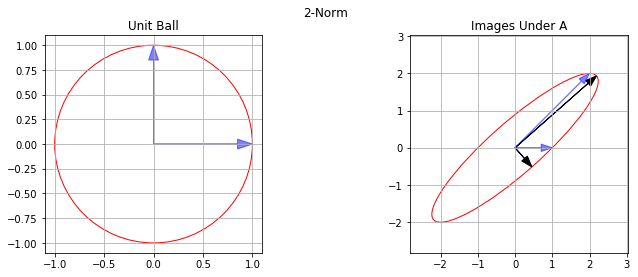

In [42]:
# ============
# 2-norm

# Unit-ball
fig = plt.figure()
fig.suptitle("2-Norm")
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.add_artist(plt.Circle((0.0, 0.0), 1.0, edgecolor='r', facecolor='none'))
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
# Compute some geometry
u, s, v = numpy.linalg.svd(A)
theta = numpy.empty(A.shape[0])
ellipse_axes = numpy.empty(A.shape)
theta[0] = numpy.arccos(u[0][0]) / numpy.linalg.norm(u[0], ord=2)
theta[1] = theta[0] - numpy.pi / 2.0
for i in range(theta.shape[0]):
    ellipse_axes[0, i] = s[i] * numpy.cos(theta[i])
    ellipse_axes[1, i] = s[i] * numpy.sin(theta[i])

axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.add_artist(patches.Ellipse((0.0, 0.0), 2 * s[0], 2 * s[1], theta[0] * 180.0 / numpy.pi,
                                edgecolor='r', facecolor='none'))
for i in range(A.shape[0]):
    axes.arrow(0.0, 0.0, ellipse_axes[0, i] - head_length * numpy.cos(theta[i]), 
                         ellipse_axes[1, i] - head_length * numpy.sin(theta[i]), 
                         head_width=head_width, color='k')
draw_unit_vectors(axes, A, head_width=0.2)
axes.set_title("Images Under A")
axes.set_xlim((-s[0] + 0.1, s[0] + 0.1))
axes.set_ylim((-s[0] + 0.1, s[0] + 0.1))
axes.grid(True)

plt.show()

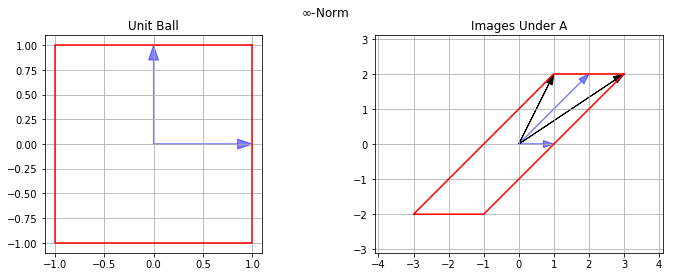

In [43]:
# ============
# infty-norm
# Unit-ball
fig = plt.figure()
fig.suptitle("$\infty$-Norm")
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.plot((1.0, -1.0, -1.0, 1.0, 1.0), (1.0, 1.0, -1.0, -1.0, 1.0), 'r')
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
# Geometry - Corners are A * ((1, 1), (1, -1), (-1, 1), (-1, -1))
# Symmetry implies we only need two.  Here we just plot two
u = numpy.empty(A.shape)
u[:, 0] = numpy.dot(A, numpy.array((1.0, 1.0)))
u[:, 1] = numpy.dot(A, numpy.array((-1.0, 1.0)))
theta[0] = numpy.arccos(u[0, 0] / numpy.linalg.norm(u[:, 0], ord=2))
theta[1] = numpy.arccos(u[0, 1] / numpy.linalg.norm(u[:, 1], ord=2))

axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.plot((3, 1, -3, -1, 3), (2, 2, -2, -2, 2), 'r')
for i in range(A.shape[0]):
    axes.arrow(0.0, 0.0, u[0, i] - head_length * numpy.cos(theta[i]), 
                         u[1, i] - head_length * numpy.sin(theta[i]), 
                         head_width=head_width, color='k')

draw_unit_vectors(axes, A, head_width=0.2)
axes.set_title("Images Under A")
axes.set_xlim((-4.1, 4.1))
axes.set_ylim((-3.1, 3.1))
axes.grid(True)

plt.show()

#### Cauchy-Schwarz and Hölder Inequalities

Computing matrix norms where $p \neq 1$ or $\infty$ is more difficult unfortunately.  We have a couple of tools that can be useful however.  

 - **Cauchy-Schwarz Inequality**:  For the special case where $p=q=2$, for any vectors $\mathbf{x}$ and $\mathbf{y}$
$$
    |\mathbf{x}^*\mathbf{y}| \leq ||\mathbf{x}||_2 ||\mathbf{y}||_2
$$
 - **Hölder's Inequality**:  Turns out this holds in general if given a $p$ and $q$ that satisfy $1/p + 1/q = 1$ with $1 \leq p, q \leq \infty$

$$
    |\mathbf{x}^*\mathbf{y}| \leq ||\mathbf{x}||_p ||\mathbf{y}||_q.
$$

#### General Matrix Norms (induced and  non-induced)

In general matrix-norms have the following properties whether they are induced from a vector-norm or not:
1. $||A|| \geq 0$ and $||A|| = 0$ only if $A = 0$
1. $||A + B|| \leq ||A|| + ||B||$ (Triangle Inequality)
1. $||c A|| = |c| ||A||$

The most widely used matrix norm not induced by a vector norm is the **Frobenius norm** defined by
$$
    ||A||_F = \left( \sum^m_{i=1} \sum^n_{j=1} |A_{ij}|^2 \right)^{1/2}.
$$

#### Invariance under unitary multiplication

One important property of the matrix 2-norm (and Forbenius norm) is that multiplication by a unitary matrix does not change the product (kind of like multiplication by 1).  In general for any $A \in \mathbb{C}^{m\times n}$ and unitary matrix $Q \in \mathbb{C}^{m \times m}$ we have
\begin{align*}
    ||Q A||_2 &= ||A||_2 \\ ||Q A||_F &= ||A||_F.
\end{align*}

<sup>1</sup><span id="footnoteRegression"> http://www.utstat.toronto.edu/~brunner/books/LinearModelsInStatistics.pdf</span>